# Pip install & Import library

In [ ]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 88.9 MB/s eta 0:00:00


In [ ]:
from fastai.vision.all import *
from fastai.callback import *
import fastai
import cv2
import glob
import pandas as pd
import os
from torchvision import transforms
import timm
import timm.optim
from timm.data.transforms_factory import create_transform
from torch.optim import lr_scheduler
from fastai.vision.all import *
from timm import create_model
from fastai.metrics import mae
import shutil
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Image Preprocessing

In [ ]:
path_train = "/content/clahe/train/AP/"
path_test = "/content/clahe/test/"
output_path_train = '/content/clahe/test/'
output_path_test = '/content/clahe/train/AP/'

In [ ]:
def apply_clahe(image_path, clip_limit=2.0, tile_grid_size=(8, 8)):
    # Load the image
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)

    # Convert the image to LAB color space
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

    # Split the LAB image into L, A, and B channels
    l, a, b = cv2.split(lab)

    # Apply CLAHE to the L channel
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    clahe_l = clahe.apply(l)

    # Merge the enhanced L channel with the original A and B channels
    enhanced_lab = cv2.merge((clahe_l, a, b))

    # Convert the enhanced LAB image back to BGR color space
    enhanced_image = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2BGR)

    return enhanced_image

# Directory path containing the images and CSV files
directory = path_train
output_folder = output_path_train

# Create the output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Traverse the directory and find image files and CSV files
image_files = []
csv_files = []

for dire
  for root, dirs, files in os.walk(directory):
      for file in files:
          # Check if the file is an image file
          if file.endswith(('.jpg', '.jpeg', '.png', '.bmp')):
              # Get the full path of the image file
              image_path = os.path.join(root, file)
              image_files.append(image_path)
          # Check if the file is a CSV file
          if file.endswith('.csv'):
              # Get the full path of the CSV file
              csv_path = os.path.join(root, file)
              csv_files.append(csv_path)

# Process the images with a progress bar
for image_path in tqdm(image_files, desc='Processing images'):
    # Apply CLAHE to the image
    enhanced_image = apply_clahe(image_path)

    # Construct the output path for the image
    relative_path = os.path.relpath(image_path, directory)
    output_image_path = os.path.join(output_folder, relative_path)

    # Create the output directory if it doesn't exist
    os.makedirs(os.path.dirname(output_image_path), exist_ok=True)

    # Save the enhanced image to the output path
    cv2.imwrite(output_image_path, enhanced_image)

# Copy the CSV files to the output folder
for csv_path in csv_files:
    # Construct the output path for the CSV file
    relative_path = os.path.relpath(csv_path, directory)
    output_csv_path = os.path.join(output_folder, relative_path)

    # Create the output directory if it doesn't exist
    os.makedirs(os.path.dirname(output_csv_path), exist_ok=True)

    # Copy the CSV file to the output path
    shutil.copy2(csv_path, output_csv_path)



Processing images: 100%|██████████| 200/200 [01:17<00:00,  2.58it/s]


# Prepare Data

In [ ]:
def prepare_data():
  #For train
  data = glob.glob(path_train+'*.jpg')
  final_res = pd.DataFrame([])
  for i in data:
    image_name = os.path.basename(i)
    myimg = Image.open(path_train+image_name)
    width, height = myimg.size
    ## add by tee สุดหล่อ ##
    df1 = pd.DataFrame([image_name], columns=['image_name'])
    csv_file = pd.read_csv(path_train+image_name.replace('.jpg','.csv'), header=None)
    df2 = csv_file.loc[:,:3].values.reshape(-1)
    for i in range(len(df2)):
        if i%2==0:
            df2[i] *= width
        else:
            df2[i] *= height
    ## add by tee สุดหล่อ ##
    df2 = pd.DataFrame(df2).T
    df2.columns = ['lm{}'.format(i) for i in range(len(df2.T))]
    res = pd.concat([df1, df2], axis=1)

    final_res = pd.concat([final_res, res], axis=0)
  df_train = final_res.reset_index(drop=True)
  #For test df
  list_keep = []
  for image_name in os.listdir(path_test):
    list_keep.append(image_name)
  df_test = pd.DataFrame({'image_name':list_keep})
  df_test = df_test.sort_values('image_name')
  df_test['image_name'] = path_test+df_test['image_name']
  return df_train, df_test

In [ ]:
df_train = prepare_data()[0]
df_test = prepare_data()[1]

In [ ]:
df_train

,image_name,lm0,lm1,lm2,lm3,lm4,lm5,lm6,lm7,lm8,...,lm30,lm31,lm32,lm33,lm34,lm35,lm36,lm37,lm38,lm39
0,316_AP.jpg,891.9175,342.2643,1225.4800,337.9135,884.6661,549.6532,1232.7310,549.6532,891.9175,...,1262.7980,1407.1530,861.7271,1397.673,1259.9600,1427.863,836.8071,1569.195,1251.5850,1606.902
1,115_AP.jpg,940.0643,441.7788,1317.6310,446.9158,932.3588,616.4355,1309.9260,624.1410,933.4086,...,1306.9080,1466.0460,863.0098,1535.952,1322.7680,1533.384,873.2838,1774.821,1317.6310,1761.978
2,286_AP.jpg,810.5443,664.3990,1085.9720,638.5425,832.1692,812.3401,1124.1950,788.0605,837.5172,...,1106.3230,1538.3570,720.5764,1494.371,1078.2040,1533.753,700.3534,1693.408,1065.4310,1718.953
3,207_AP.jpg,856.1080,395.3504,1247.0980,417.1528,856.1080,561.0486,1239.8300,565.4092,851.7475,...,1313.9580,1337.2140,889.5383,1444.773,1309.5980,1427.331,898.2593,1584.308,1334.3070,1581.401
4,130_AP.jpg,1234.3280,784.7383,1557.2150,756.1281,1250.6770,950.2690,1587.8690,909.3973,1279.2870,...,1788.1410,1559.2590,1377.3790,1641.002,1771.7920,1579.695,1363.0740,1786.097,1784.0540,1763.618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,213_AP.jpg,948.2010,582.2089,1314.1930,603.6054,916.6694,763.5158,1320.9500,789.4167,924.5523,...,1341.2200,1591.2210,899.7775,1682.437,1352.4820,1672.302,905.4081,1893.024,1360.3640,1870.501
396,337_AP.jpg,848.1395,452.9065,1184.0030,442.7288,856.6208,646.2823,1207.7510,629.3195,856.6208,...,1231.4990,1513.0810,822.6953,1591.110,1233.1950,1596.198,813.3430,1759.452,1242.6380,1762.844
397,12_AP.jpg,509.8673,396.3907,739.1522,434.4753,473.3372,533.9617,701.4348,552.8632,473.0311,...,974.9540,966.5353,711.9838,1067.201,971.8305,1034.411,696.6842,1201.629,969.0696,1199.143
398,314_AP.jpg,767.3448,629.4919,1048.7310,642.1577,751.0839,803.0138,1046.1980,828.3455,744.7509,...,1032.2650,1609.8270,664.9562,1666.823,1025.9320,1680.756,647.7145,1854.317,1020.8660,1879.445


In [ ]:
def getPointCoordinates(filename):
    singleDFEntry = df_train[df_train.image_name == filename[len(path_train):]]
    onlyDFCoordinates = singleDFEntry.drop(columns='image_name')
    numpyMatrix = onlyDFCoordinates.values.reshape(-1,2)
    numpyMatrix[:, 0], numpyMatrix[:, 1] = numpyMatrix[:, 0], numpyMatrix[:, 1].copy()
    return torch.from_numpy(numpyMatrix).float()

In [ ]:
coordinates = []
for row in range(df_train.shape[0]):
    name_image = df_train.iloc[row, 0]
    coordinate = [tuple(arr) for arr in getPointCoordinates(path_train + name_image)]
    coordinates.append(coordinate)

In [ ]:
df_path = pd.DataFrame(df_train['image_name'])
df_path['image_name'] = path_train+df_path['image_name']
df_coordinate = pd.DataFrame({'coordinate':coordinates})
df_train = pd.concat([df_path,df_coordinate],axis=1)

In [ ]:
torch.backends.cuda.cufft_plan_cache.max_split_size_mb = 1000

In [ ]:
timm.list_models("*dense*")

['densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'densenet264d',
 'densenetblur121d']

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


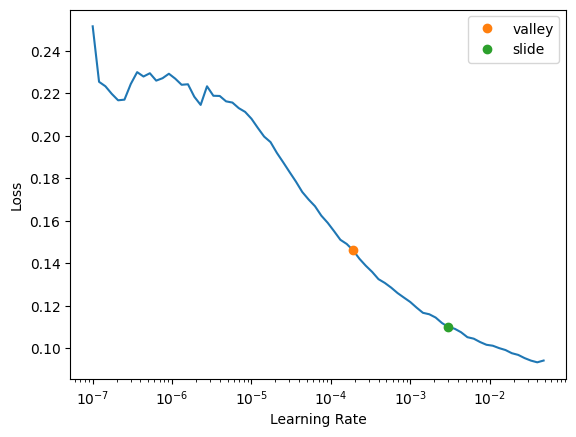

In [ ]:
# Create a DataBlock for keypoint regression
dblock = DataBlock(blocks=(ImageBlock, PointBlock),
                   get_x=ColReader('image_name'),
                   get_y=ColReader('coordinate'),
                   splitter=RandomSplitter(),
                   item_tfms=Resize(256))

# Create a DataLoaders object
model = create_model('swinv2_base_window8_256', pretrained=True, num_classes=40)
dls = dblock.dataloaders(df_train, bs=16)
# dls.show_batch()
learn = Learner(dls, model, metrics=mae).to_fp16()
learning_rate = learn.lr_find(suggest_funcs=(valley, slide))


In [ ]:
learn.fit_one_cycle(3,learning_rate[0])

epoch,train_loss,valid_loss,mae,time
0,0.083829,0.026558,0.118931,01:01
1,0.054093,0.012636,0.082391,01:01
2,0.034896,0.009250,0.071830,01:01


In [ ]:
learn.unfreeze()

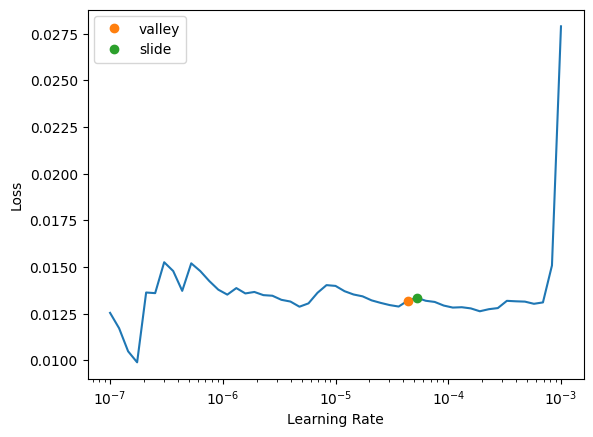

In [ ]:
learning_rate = learn.lr_find(suggest_funcs=(valley, slide))

In [ ]:
learn.fit_one_cycle(48, lr_max=slice(learning_rate[0],learning_rate[1]))

In [ ]:
learn.export('swinv2_base_window8_256_72_epochs')

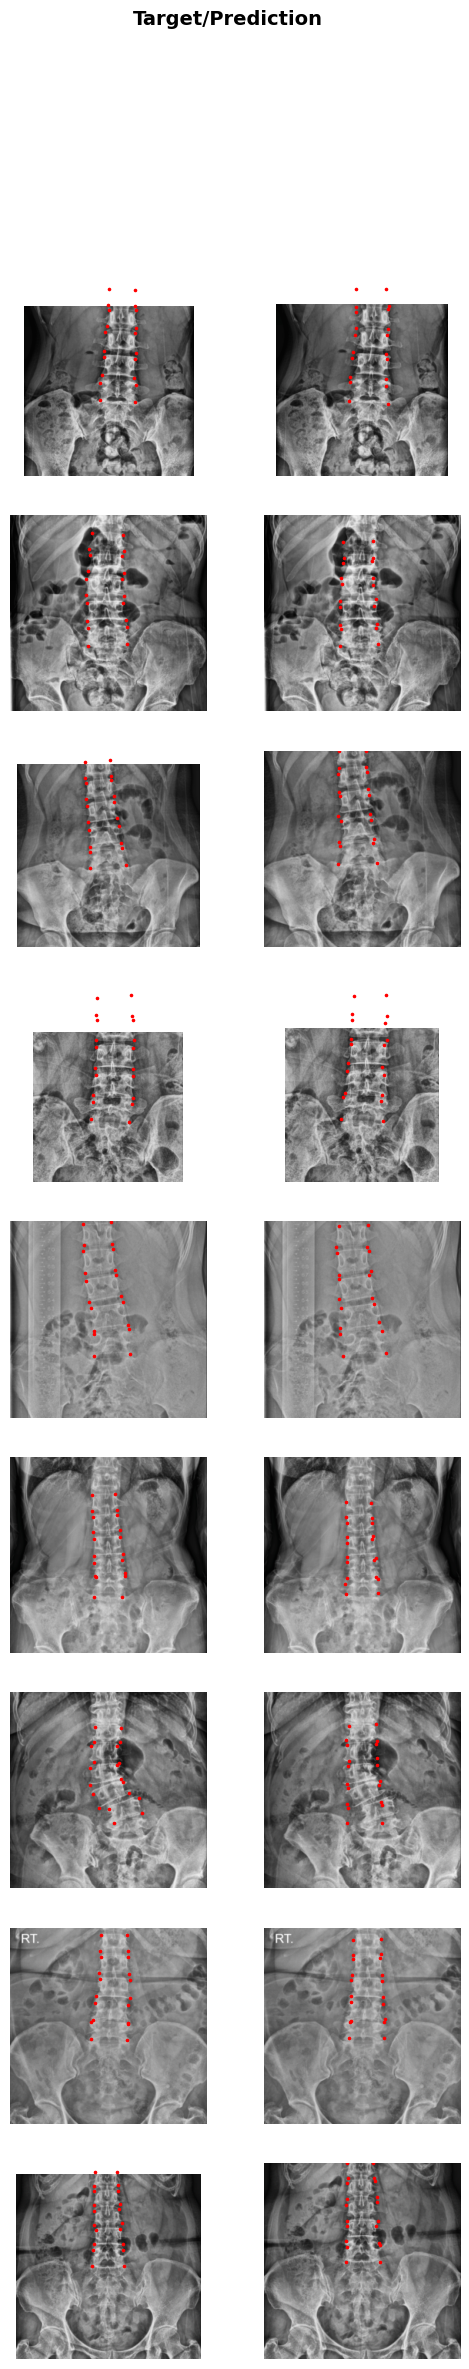

In [ ]:
learn.show_results()

In [ ]:
test_dl = dls.test_dl(df_test)

In [ ]:
preds, _ = learn.get_preds(dl=test_dl)

In [ ]:
def Visualize(row):
  image = cv2.imread(df_test.iloc[row,0])
  width = image.shape[1]
  height = image.shape[0]
  label = abs((preds[row].numpy()+1)/2)
  label = label.reshape(-1,2)
  plt.imshow(image)
  plt.scatter(label[:, 0]*width, label[:, 1]*height, s=10, marker='.', c='r')
  plt.pause(0.001)



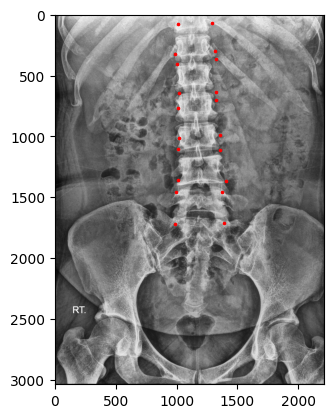

In [ ]:
Visualize(8)

In [ ]:
def save_result():
  cols = ['id','L1a_1c','L1a_1r','L1a_2c','L1a_2r','L1b_1c','L1b_1r','L1b_2c','L1b_2r','L2a_1c','L2a_1r','L2a_2c','L2a_2r',
           'L2b_1c','L2b_1r','L2b_2c','L2b_2r','L3a_1c','L3a_1r','L3a_2c','L3a_2r','L3b_1c','L3b_1r','L3b_2c','L3b_2r',
           'L4a_1c','L4a_1r','L4a_2c','L4a_2r','L4b_1c','L4b_1r','L4b_2c','L4b_2r','L5a_1c','L5a_1r','L5a_2c','L5a_2r',
           'L5b_1c','L5b_1r','L5b_2c','L5b_2r']
  mydata = []
  df_test['id'] = df_test['image_name'].apply(lambda x: x.replace(path_train, ''))
  result1 = pd.DataFrame(df_test['id'])
  for row in range(len(preds)):
    label = abs((preds[row].numpy()+1)/2)
    mydata.append(label)
  result2 = pd.DataFrame(mydata)
  result2.columns = cols[1:]
  result = pd.concat([result1,result2],axis=1)
  result_sort = result.sort_values('id')
  result_sort.to_csv('ar_result.csv', index=False)





In [ ]:
save_result()